# Creating an artificial neural network from scratch

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

[OK] Your Python version is 3.9.23 | packaged by conda-forge | (main, Jun  4 2025, 17:49:16) [MSC v.1929 64 bit (AMD64)]
[OK] numpy 2.0.2
[OK] matplotlib 3.9.4
[OK] sklearn 1.6.1


In [3]:
from IPython.display import Image
%matplotlib inline

In [4]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [5]:
X = X.values
y = y.astype(int).values

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
# Scale X to [-1, 1]
X = ((X / 255.) - 0.5) * 2

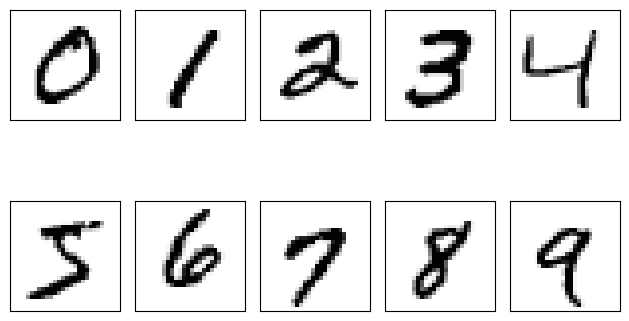

In [9]:
# Visualizing the images
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

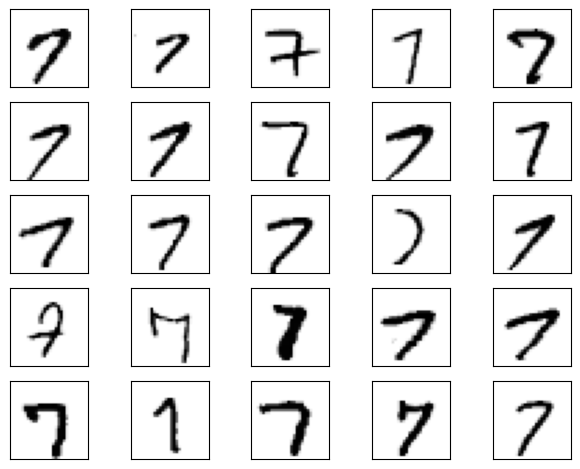

In [10]:
fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_yticks([])
ax[0].set_xticks([])
plt.tight_layout()
plt.show()

In [11]:
# Split into 55,000 training, 5,000 validation, and 10,000 test samples
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, 
                                                  test_size=5000, random_state=123, stratify=y_temp)

In [12]:
# Implementing MLP 
import numpy as np 

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def int_to_onehot(y, num_classes):
    ary = np.zeros((y.shape[0], num_classes))
    for idx, val in enumerate(y):
        ary[idx, val] = 1
    return ary

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_state=123):
        super().__init__()
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_state)

        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, X):
        # hidden 
        # input dim: [n_hidden, n_features] dot [n_features, n_examples].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(X, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # output
        # input dim: [n_classes, n_hidden] dot [n_hidden, n_examples].T 
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        ### Output layer weights ###

        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        ## Part 1: 
        # dLoss/dWeights = dLess/dOutAct * dOutAct/dOutNet * dOutNet/dWeight
        # where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        ## Part 2: 
        # dLoss/dHidden = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeights

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_hidden]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss_a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)

In [13]:
def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [14]:
model = NeuralNetMLP(num_features=28*28, num_hidden=50, num_classes=10)

In [15]:
# Coding the training loop
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, X.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [16]:
# Confirm that this works first
for i in range(num_epochs):
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape, y_train_mini.shape)

(100, 784) (100,)


In [17]:
# Define loss function
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels)
    return(np.mean((probas - onehot_targets) ** 2))

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [18]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f"Initial validation MSE: {mse:.1f}")

Initial validation MSE: 0.3


In [19]:
predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc * 100:.1f}%')

Initial validation accuracy: 9.4%


In [20]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / i
    acc = correct_pred / num_examples
    return mse, acc

In [21]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')

Initial valid MSE: 0.3


In [22]:
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid accuracy: 9.4%


In [23]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # Iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            ### Compute outputs ###
            a_h, a_out = model.forward(X_train_mini)

            ### Compute gradients ###
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train_mini, a_h, a_out, y_train_mini)

            ### Update weights ### 
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        ### Epoch logging ###
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [24]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid, num_epochs = 50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

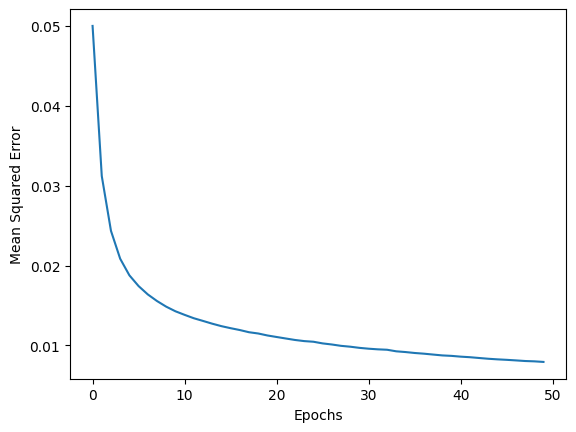

In [25]:
# Evaluating performance
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel("Mean Squared Error")
plt.xlabel("Epochs")
plt.show()

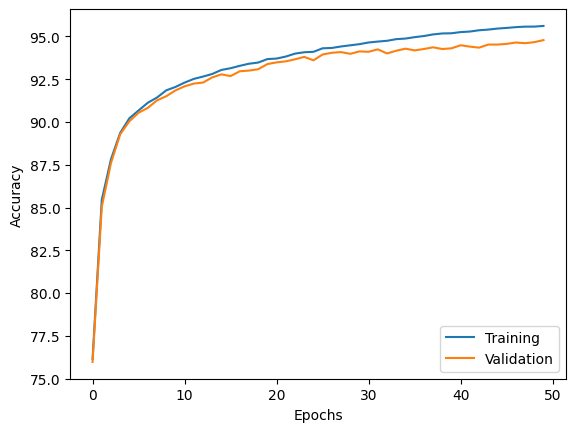

In [26]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(loc="lower right")
plt.show()

In [27]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test MSE: {test_acc*100:.2f}%')

Test MSE: 94.54%
